# Welcome to the cooltools expected notebook!

Hi-C contact maps contain a variety of patterns - that is why it can be difficult to analyse sometimes. :) 
Yet, a typical Hi-C map is dominated by a single pattern, the decay of contact frequency with genomic separation. In the Hi-C field, this decay is often referred to as "expected" (because one "expects" a certain average contact frequency at a given genomic separation) or "scaling" (which is borrowed from the polymer physics literature) or P(s) curve (contact *probability*, P, as a function of genomic *separation*, s). The monotonic decay of contacts with genomic separation is reflective of the polymeric nature of chromosomes and can tell us about the global folding patterns of the genome. 

The goals of this notebook are:
- calculate the P(s) of a given cooler
- plot the P(s) curve
- smooth the P(s) curve with logarithmic binning
- plot the derivative of P(s)
- plot the P(s) between two different genomic regions
- plot the matrix of average contact frequencies between different chromosomes

In [1]:
# import core packages
import warnings
warnings.filterwarnings("ignore")
from itertools import combinations

# import semi-core packages
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline
plt.style.use('seaborn-poster')
import numpy as np
import pandas as pd

# import open2c libraries
import bioframe

import cooler
import cooltools
import cooltools.expected

In [2]:
# Download the test data from osf. 
# This requires a client application installed in the current python environment.

# %pip install osfclient
#!osf -p hjcxg fetch osfstorage/test.mcool ./test.mcool

In [3]:
# Load a Hi-C map at a 1kb resolution from a cooler file.
clr = cooler.Cooler('./test.mcool::/resolutions/1000')

In [4]:
# Use bioframe to fetch the genomic features from the UCSC.

hg38_chromsizes = bioframe.fetch_chromsizes('hg38', as_bed=True)
hg38_cens = bioframe.fetch_centromeres('hg38')
hg38_arms = bioframe.split(hg38_chromsizes, hg38_cens, cols_points=['chrom', 'mid'])

# Select only chromosomes that are present in the cooler. 
# This step is typically not required! we call it only because the test data are reduced. 
hg38_chromsizes = hg38_chromsizes.set_index("chrom").loc[clr.chromnames].reset_index() 
hg38_arms = hg38_arms.set_index("chrom").loc[clr.chromnames].reset_index()
# call this to automaticly assign names to chromosomal arms:
hg38_arms = bioframe.parse_regions(hg38_arms)

### Calculate the P(s) curve

To calculate the average contact frequency as a function of genomic separation, we will rely on the fact that each diagonal of a Hi-C map contains interactions between loci separated by the same distance. For example, the 3rd diagonal of our matrix contains interactions between loci separated by 3-4kb (note that diagonals are 0-indexed). Thus, we calculate the average P(s) at a given distance s as the average value of all pixels of the corresponding diagonal. This operation is performed by `cooltools.expected.diagsum`.

Note that we calculate the P(s) separately for each chromosomal **arm**. This way we will ignore interactions accross the centromere, which is generally a good idea, since such interacts typically decay differently.

In [5]:
# cvd == contacts-vs-distance
cvd = cooltools.expected.diagsum(
    clr=clr,
    regions=hg38_arms,
    transforms={'balanced': lambda p: p['count']*p['weight1']*p['weight2']}
)

At its name suggests, `cooltools.expected.diagsum` calculates the sum of raw and normalized interaction counts (`count.sum` and `balanced.sum`) for each diagonal of a Hi-C map.
It also provides the number of valid (i.e. non-masked) pixels at each diagonal, `n_valid`, so that we can calculate the average contact frequency later.

In [6]:
display(cvd.head(4))
display(cvd.tail(4))

,region,diag,n_valid,count.sum,balanced.sum
0,chr2:0-93139351,0,86055,NaN,NaN
1,chr2:0-93139351,1,85282,NaN,NaN
2,chr2:0-93139351,2,84918,10859113.0,8344.916674
3,chr2:0-93139351,3,84649,4742194.0,3623.417357


,region,diag,n_valid,count.sum,balanced.sum
325450,chr17:24714921-83257441,58540,0,0.0,0.0
325451,chr17:24714921-83257441,58541,0,0.0,0.0
325452,chr17:24714921-83257441,58542,0,0.0,0.0
325453,chr17:24714921-83257441,58543,0,0.0,0.0


Note that the data from first couple of diagonals are masked. We do this intentionally, since interactions at these diagonals (very short-ranged) are contaminated by non-informative Hi-C byproducts - dangling ends and self-circles. 

`cooltools.expected.diagsum` treats each genomic regions separately and does not aggregate the results automatically. This reflects the overall philosophy of cooltools, according to which we strive to provide access to data at different levels of aggregation (e.g., if the user wants to check if P(s) differs between regions). At this stage, we are only interested in the genome-average P(s), so we need to aggregate results from different regions together. This can be done easily via the pandas groupby functionality:

In [7]:
# Aggregate diagonals from different genomic regions together. 
# Since all three calcuated statistics are additive, they can be aggregated
# easily via sum() functiond.
cvd_agg = (
    cvd
    .groupby('diag')
    .agg(
        {'n_valid':'sum',
         'count.sum':'sum',
         'balanced.sum':'sum',
        })
    .reset_index()
)

# Convert indices of diagonals into genomic separation, expressed in basepairs.
cvd_agg['s_bp'] = (
    cvd_agg['diag'] 
    * clr.binsize)

# Now we can calculate the average raw interaction counts and normalized contact frequencies.
cvd_agg['count.avg'] = (
    cvd_agg['count.sum']
    / cvd_agg['n_valid']
)

cvd_agg['balanced.avg'] = (
    cvd_agg['balanced.sum']
    / cvd_agg['n_valid']
)

### Plot the P(s) curve

Time to plot our P(s)! 
The challenge here is that Hi-C has a uniquely wide dynamic range. Hi-C probes genomic separations ranging from 100s to 100,000,000s of basepairs; the contact frequencies too tend to span many orders of magnitude.
Plotting such data in the linear scale would reveal only a part of the whole picture. Instead, we should switch to double logarithmic (aka log-log) coordinates, where the x and y coordinates would correspond to the orders of magnitude of our data.

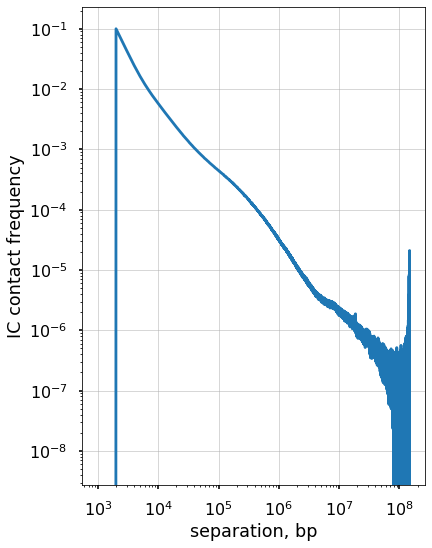

In [8]:
f, ax = plt.subplots(1,1)
ax.loglog(
    cvd_agg['s_bp'],
    cvd_agg['balanced.avg'],
)
ax.set(
    xlabel='separation, bp', 
    ylabel='IC contact frequency')
ax.set_aspect(1.0)
ax.grid(lw=0.5)

With this data, we also have an opportunity to test the effect of matrix balancing on the P(s) curve. Though, raw and balanced Hi-C data have different units, counts vs frequencies-that-sum-to-1.0. So, to plot the two on the same canvas, we have to normalize them to the same scale. Generally, there is no "best" way to normalize P(s) curves, different approaches rely on different assumptions, which are almost never true. The simplest assumption we can make is that our two P(s) curves must match at short distances.

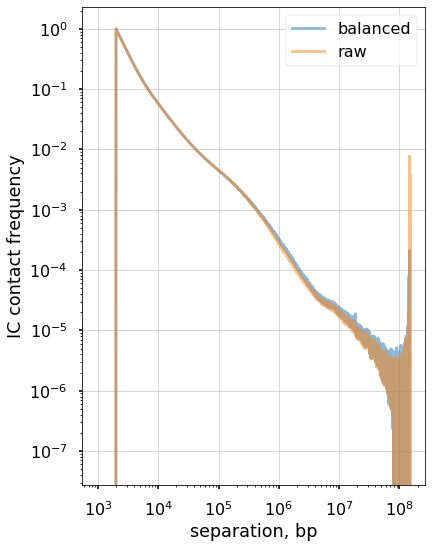

In [9]:
f, ax = plt.subplots(1,1)
# Below we normalize both P(s) curves by their first non-zero value 
# (remember that we mask the first 2 diagonals).
ax.loglog(
    cvd_agg['s_bp'],
    cvd_agg['balanced.avg'] / cvd_agg['balanced.avg'].iloc[2],
    alpha=0.5,
    label='balanced'
)
ax.loglog(
    cvd_agg['s_bp'],
    cvd_agg['count.avg'] / cvd_agg['count.avg'].iloc[2],
    alpha=0.5,
    label='raw'
)

ax.set(
    xlabel='separation, bp', 
    ylabel='IC contact frequency')
ax.set_aspect(1.0)
ax.grid(lw=0.5)
_=ax.legend()

As you can see, the shape of P(s) curves is *almost* not affected by balancing.

### Smooth the P(s) curve with logarithmic binning.

The curves plotted above form characteristic "fans" at longer separations. This happens for two reasons: (a) we plot values of **each** diagonal separately and thus each decade of s contains 10x more points, and (b) due to the polymer nature of chromosomes, interactions at longer separations are weaker and thus more affected by counting noise.  

This issue is more that just cosmetic, as this noise would prevent us from doing finer analyses of P(s) and propagate into data derived from P(s). However, there is a simple solution: we can calculate P(s) not for individual diagonals, but rather for whole groups of consecutive diagonals (a.k.a. distance bins). This works, because P(s) changes very gradually with s, so that consecutive diagonals have very similar values. Furthermore, we can make each next distance bin wider than the previous one, so that each order of magnitude of s is contains the same number of bins. Such aggregation is a bit involving, but `cooltools.expected` provides this function out of the box.

In [10]:
# Logbin-expected aggregates P(s) curves per region over exponentially increasing distance bins.
lb_cvd, lb_slopes, lb_distbins = cooltools.expected.logbin_expected(cvd)

# The resulting table contains P(s) curves for each individual region.
# Aggregating these curves into a single genome-wide curve is involving too, 
# so we created a separate function for this too.
lb_cvd_agg, lb_slopes_agg = cooltools.expected.combine_binned_expected(
    lb_cvd,
    binned_exp_slope=lb_slopes
)

lb_cvd_agg['s_bp'] = lb_cvd_agg['x'] * clr.binsize 
lb_slopes_agg['s_bp'] = lb_slopes_agg['x'] * clr.binsize 

### Plot the smoothed P(s) curve and its derivative

Logbin-smoothing of P(s) reduces the "fanning" at longer s and enables us to plot the derivative of the P(s) curve in the log-log space. This derivative is extremely informative, as it can be compared to predictions from various polymer models.

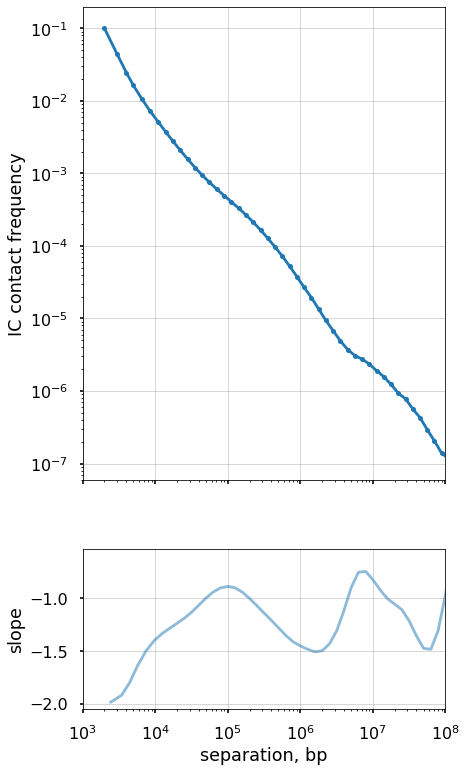

In [11]:
f, axs = plt.subplots(
    figsize=(6.5,13),
    nrows=2, 
    gridspec_kw={'height_ratios':[6,2]}, 
    sharex=True)
ax = axs[0]
ax.loglog(
    lb_cvd_agg['s_bp'],
    lb_cvd_agg['Pc'],
    'o-',
    markersize=5,
)

ax.set(
    ylabel='IC contact frequency',
    xlim=(1e3,1e8)
)
ax.set_aspect(1.0)
ax.grid(lw=0.5)


ax = axs[1]
ax.semilogx(
    lb_slopes_agg['s_bp'],
    lb_slopes_agg['slope'],
    alpha=0.5
)

ax.set(
    xlabel='separation, bp', 
    ylabel='slope')

ax.grid(lw=0.5)

### Plot the P(s) curve for interactions between different regions.

Finally, we can plot P(s) curves for interactions between loci that belong to different regions. An obvious example is the trans-arm interactions, i.e. interactions between loci on the opposite side of a centromere. Such P(s) can be calculated via `cooltools.expected.diagsum_asymm`

In [12]:
# create two sets of left and right arms, matching each other (cis-ones):
gb = hg38_arms.groupby('chrom')
left_arms = gb.nth(0).reset_index()
right_arms = gb.nth(1).reset_index()

In [13]:
# cvd_inter == contacts-vs-distance between chromosomal arms
# The region pairs must be provided as two lists with syncronyzed order.
cvd_inter = cooltools.expected.diagsum_asymm(
    clr=clr,
    regions1=left_arms,
    regions2=right_arms,
    transforms={'balanced': lambda p: p['count']*p['weight1']*p['weight2']}
)

In [14]:
# Logbin-expected aggregates P(s) curves per region over exponentially increasing distance bins.
cvd_inter['region'] = cvd_inter['region1'] + '&' + cvd_inter['region2']
lb_inter_cvd, lb_inter_slopes, lb_inter_distbins = cooltools.expected.logbin_expected(cvd_inter)

# The resulting table contains P(s) curves for each individual region.
# Aggregating these curves into a single genome-wide curve is involving too, 
# so we created a separate function for this too.
lb_cvd_inter_agg, lb_inter_slopes_agg = cooltools.expected.combine_binned_expected(
    lb_inter_cvd,
    lb_inter_slopes
)

lb_cvd_inter_agg['s_bp'] = lb_cvd_inter_agg['x'] * clr.binsize 
lb_inter_slopes_agg['s_bp'] = lb_inter_slopes_agg['x'] * clr.binsize 


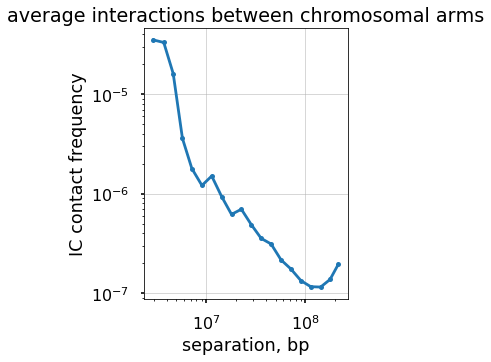

In [15]:
f, ax = plt.subplots(1,1,
    figsize=(5,5),)

ax.loglog(
    lb_cvd_inter_agg['s_bp'],
    lb_cvd_inter_agg['Pc'],
    marker='o',
    markersize=5,
)


ax.set(
    xlabel='separation, bp', 
    ylabel='IC contact frequency',
    title="average interactions between chromosomal arms")
ax.grid(lw=0.5)
ax.set_aspect(1.0)


### Averaging interaction frequencies in blocks

For *trans* (i.e. inter-chromosomal) interactions, the notion of "genomic separation" becomes irrelevant, as loci on different chromosomes are not connected by any polymer chain. Thus, the "expected" level of trans interactions is a scalar, the average interaction frequency for a given pair of chromosomes.

In [16]:
# create pairwise combinations of chromosomes for calculating average interactions:
regions = hg38_chromsizes['chrom'].to_list()
region_pairs = list(combinations(regions, 2)) 

In [17]:
# average contacts, in this case between pairs of chromosomal arms:
ac = cooltools.expected.blocksum_asymm(
    clr=clr,
    regions1=[i[0] for i in region_pairs],
    regions2=[i[1] for i in region_pairs],
    transforms={'balanced': lambda p: p['count']*p['weight1']*p['weight2']}
)

# Now we can calculate the average raw interaction counts and normalized contact frequencies.
ac["balanced.avg"] = (
    ac["balanced.sum"]
    / ac["n_valid"]
)

In [18]:
# pivot a table to generate a pair-wise average interaction heatmap:
acp = (ac 
    .pivot_table(values="balanced.avg",
                 index="region1",
                 columns="region2",
                 observed=True) 
    .reindex(index=regions,
             columns=regions)
)

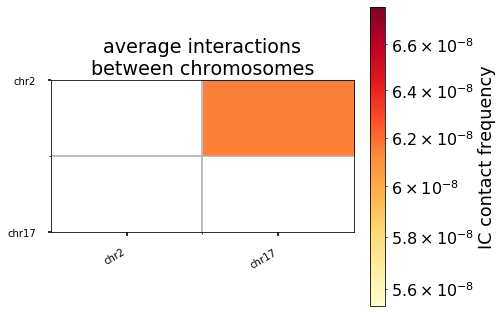

In [20]:
f, axs = plt.subplots(
    figsize=(6.0,5.5),
    ncols=2,
    gridspec_kw={'width_ratios':[20,1],"wspace":0.1},
)
# assign heatmap and colobar axis:
ax, cax = axs
# draw a heatmap, using log-scale for interaction freq-s:
acpm = ax.imshow(
    acp,
    cmap="YlOrRd",
    norm=colors.LogNorm(),
    aspect=1.0
)
# assign ticks and labels (ordered names of chromosome arms):
ax.set(
    xticks=range(len(regions)),
    yticks=range(len(regions)),
    title="average interactions\nbetween chromosomes",
)
ax.set_xticklabels(
    regions,
    rotation=30,
    horizontalalignment='right',
    fontsize=10
)
ax.set_yticklabels(
    regions,
    fontsize=10
)
# draw a colorbar of interaction frequencies for the heatmap:
f.colorbar(
    acpm,
    cax=cax,
    label='IC contact frequency'
)

# draw a grid around values:
ax.set_xticks(
    [x-0.5 for x in range(1,len(regions))],
    minor=True
)
ax.set_yticks(
    [y-0.5 for y in range(1,len(regions))],
    minor=True
)
ax.grid(which="minor")
